# VQA v2.0 Interactive Notebook

## Import Libraries

In [1]:
# Import libraries
import importlib
import os
import string
from collections import Counter
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms


In [2]:
# Check GPU
if not torch.cuda.is_available():
    raise RuntimeError("GPU with CUDA support is required")
device = torch.device("cuda")


In [3]:
# Import utils
if not os.path.exists("./utils"):
    !git clone https://github.com/ZhangShaozuo/Artificial_Intelligence_VQA.git
    !ln -s ./DL-BigProject-VQA/utils ./utils

if os.path.exists("./DL-BigProject-VQA/utils"):
    !cd ./DL-BigProject-VQA/utils && git pull

import utils.data as data_util
import utils.helper as helper
import utils.train as train_util
from utils.vocab import Vocab

importlib.reload(data_util)
importlib.reload(helper)
importlib.reload(train_util)
pass


## Load Dataset

In [4]:
# Load dataset (single word answer only)
image_transform = transforms.Compose(
    [
        transforms.Resize(int(224 / 0.875)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)


def tokenizer(question: str) -> List[str]:
    # to lower case
    question = question.lower()
    # remove punctuation
    trans = str.maketrans("", "", string.punctuation)
    question = question.translate(trans)
    # split words
    return question.split()


question_vocab = Vocab({})


def question_transform(question: str):
    tokens = tokenizer(question)
    indices = [question_vocab[token] for token in tokens]
    return torch.tensor(indices, dtype=torch.long)


def question_transform_factory(corpus: Iterable[str]):
    global question_vocab
    counter = Counter()
    for text in corpus:
        counter.update(tokenizer(text))
    question_vocab = Vocab(counter, specials=["<pad>", "<unk>"])
    return question_transform


answer_vocab = Vocab({})


def answer_tansform(answer: str):
    return answer_vocab[answer]


def answer_tansform_factory(corpus: Iterable[str]):
    global answer_vocab
    answer_vocab = Vocab(Counter(corpus), specials=["<unk>"], min_freq=10)
    return answer_tansform


train_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="train",
    image_transform=image_transform,
    question_transform_factory=question_transform_factory,
    answer_transform_factory=answer_tansform_factory,
    download=True,
)

valid_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="val",
    image_transform=image_transform,
    question_transform=question_transform,
    answer_transform=answer_tansform,
)

test_dataset = data_util.VQA2Dataset(
    "./VQA2/",
    group="test",
    image_transform=image_transform,
    question_transform=question_transform,
    answer_transform=answer_tansform,
)

print("train_dataset:", len(train_dataset))
print("valid_dataset:", len(valid_dataset))
print("test_dataset:", len(test_dataset))
print()
print("quesiton_vocab size:", len(question_vocab))
print("answer_vocab size:  ", len(answer_vocab))


train_dataset: 411198
valid_dataset: 138617
test_dataset: 59678

quesiton_vocab size: 13457
answer_vocab size:   1823


In [5]:
# Save vocab
question_vocab.save("question_vocab.json")
answer_vocab.save("answer_vocab.json")


In [6]:
# Load vocab
question_vocab = Vocab.load("question_vocab.json")
answer_vocab = Vocab.load("answer_vocab.json")


## Create Dataloader

In [7]:
# Create dataloader
batch_size = 64
PAD_IDX = question_vocab["<pad>"]


def generate_batch(data_batch):
    data_batch.sort(key=lambda x: -len(x[1]))  # for pack_padded_sequence
    images, questions, answers = zip(*data_batch)
    images = torch.stack(images, 0)
    q_lengths = [len(q) for q in questions]
    questions = rnn_utils.pad_sequence(questions, padding_value=PAD_IDX)
    answers = torch.tensor(answers, dtype=torch.long)
    return images, questions, q_lengths, answers


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=generate_batch, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, collate_fn=generate_batch
)

# use a subset of the validation dataset
mini_valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    collate_fn=generate_batch,
    sampler=SubsetRandomSampler(list(range(512))),
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=generate_batch)


In [8]:
len(answer_vocab)

1823

Q: what kind of vehicle is the rv pulling on the bottom picture
A: jeep


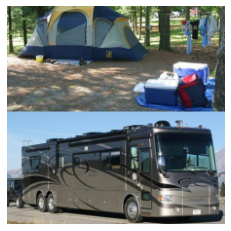

Q: why is there a gap between the roof and wall
A: yes


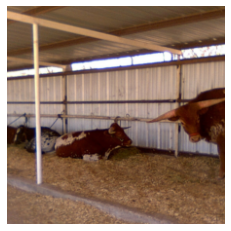

Q: will this kid leave the powdered sugar on his face
A: yes


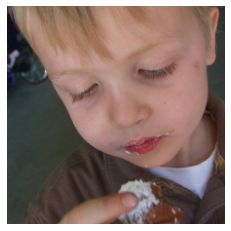

Q: what is the color of the building in the background
A: brown


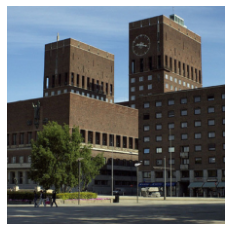

In [9]:
# Visualize some samples
def sequence_to_sentence(seq: List[int]) -> str:
    sentence = []
    for i in seq:
        if i == PAD_IDX:
            break
        sentence.append(question_vocab.itos[i])
    return " ".join(sentence)


def visualize_samples(images, questions, answers, max_num=-1):
    if max_num < 0:
        max_num = len(images)

    # PyTorch RNN is using (seq_len, batch, input_size)
    # make it (batch, seq_len, input_size)
    questions = questions.transpose(0, 1)

    for _, v, q, a in zip(range(max_num), images, questions, answers):
        print("Q:", sequence_to_sentence(q))
        print("A:", answer_vocab.itos[a])
        helper.imshow(v)
        plt.show()


images, questions, _, answers = next(iter(valid_loader))
visualize_samples(images, questions, answers, max_num=4)


## Create Model

In [36]:
class ImgNet(nn.Module):
    def __init__(self, pretrained=True, embed_size=256):
        super(ImgNet, self).__init__()
        model = torchvision.models.alexnet(pretrained=True)
        self.backbone = model

    def forward(self, images):
        x = self.backbone.features(images)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x,1)
#         return self.backbone(images)
        return x


In [37]:
class QNet(nn.Module):
    def __init__(self, vocab, embedding_dim, out_dim, weights_path=None):
        super().__init__()
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.tanh = nn.Tanh()
        self.rnn = nn.GRU(embedding_dim, out_dim)

        if weights_path:
            counter = 0
            weights = self.embedding.weight.detach().numpy()
            with open(weights_path, encoding="utf-8") as f:
                for line in f:
                    elements = line.split(" ")

                    word = elements[0]
                    if word not in question_vocab.stoi:
                        continue

                    embed = np.asarray(elements[1:], dtype="float32")
                    weights[question_vocab.stoi[word]] = embed

                    counter += 1
                    if counter / len(question_vocab) > 0.9:
                        break
            self.embedding.weight.data.copy_(torch.from_numpy(weights))

    def forward(self, q, q_len):
        embedded = self.embedding(q)
        tanhed = self.tanh(embedded)
        packed = rnn_utils.pack_padded_sequence(tanhed, q_len)
        _, features = self.rnn(packed)
        features = features.squeeze(0)
        return features


In [38]:
class Attention(nn.Module):
    def __init__(self, v_feat, q_feat, mid_feat, glimpses, drop=0.0):
        super(Attention, self).__init__()
        self.v_conv = nn.Conv2d(v_feat, mid_feat, 1, bias=False) 
        self.q_lin = nn.Linear(q_feat, mid_feat)
        self.x_conv = nn.Conv2d(mid_feat, glimpses, 1)
        self.drop = nn.Dropout(drop)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,v,q):
        v = self.v_conv(self.drop(v)) #[64, 128, 6, 6]
        q = self.q_lin(self.drop(q)) #[64,128]
        q = tile_2d_over_nd(q,v) #[64,128,6,6]
        x = self.relu(v + q)
        x = self.x_conv(self.drop(x))
        return x
    
def apply_attention(inputs, attention):
    weighted = attention * inputs 
    weighted_mean = weighted.sum(dim=-1)
    att_softmax = nn.Softmax(dim=1)(attention.view(-1,6,6)).view(-1,1,6,6)
    output = inputs * att_softmax
    return output, att_softmax

def tile_2d_over_nd(feature_vector, feature_map):
    """ Repeat the same feature vector over all spatial positions of a given feature map.
        The feature vector should have the same batch size and number of features as the feature map.
    """
    n, c = feature_vector.size()
    spatial_size = feature_map.dim() - 2
    tiled = feature_vector.view(n, c, *([1] * spatial_size)).expand_as(feature_map)
    return tiled

In [39]:
class VQANet(nn.Module):
    def __init__(self, vocab, num_classes: int, embed_size=256):
        super().__init__()
        self.v_net = ImgNet(embed_size=embed_size)
        self.q_net = QNet(vocab, 100, embed_size)

#         self.v_query = nn.Sequential(nn.Conv2d(256, 128, 1), nn.Sigmoid())
#         self.q_query = nn.Sequential(nn.Linear(256, 128), nn.Sigmoid())
#         self.attention_softmax = nn.Softmax(dim=1)

#         self.q_fc = nn.Sequential(nn.Linear(256, 256), nn.Sigmoid())
        question_features = 256
        vision_features = 256
        self.image_embed = nn.Linear(256 * 6 * 6, embed_size)
        self.classifier = nn.Sequential(
            nn.Linear(256, 512), nn.ReLU(True), nn.Linear(512, num_classes)
        )
        
        self.attention = Attention(v_feat = vision_features, q_feat=question_features,mid_feat=128, glimpses = 1, drop=0)
        self.last_attention = None

    def forward(self, v, q, q_len):
        v_feat = self.v_net(v).view(-1,256,6,6)  #[64,256,6,6] 64 is batch size
        q_feat = self.q_net(q, q_len) #[64,256]
        
        a = self.attention(v_feat,q_feat) #[64,1,6,6]
        v_final, att_softmax = apply_attention(v_feat, a) #v_final [64,256,6,6]
        self.last_attention = att_softmax
        v_embed = self.image_embed(v_final.view(-1,256*6*6))
        out = self.classifier(v_embed * q_feat)
        return out


In [40]:
embed_size=256
model = VQANet(question_vocab, len(answer_vocab), embed_size).to(device)


## Train Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

history = train_util.train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    mini_valid_loader,
    epochs=8,
    valid_every=200,
)
train_util.plot_history(history)


Epoch: 1/8 @ 2021-07-28 15:13:53.520431
 331/6425 [=>............................] - ETA: 6279s - loss: 3.108 - accuracy: 0.303 - topk_accuracy: 0.654 - val_loss: 3.130 - val_accuracy: 0.328 - val_topk_accuracy: 0.650 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_util.plot_history(history)


## Test Model

In [ ]:
# Accuracy on the mini validation set
mini_valid_loss, mini_valid_accu, mini_valid_topk_accu = train_util.validate_model(
    model, mini_valid_loader, nn.CrossEntropyLoss()
)
print("loss:", mini_valid_loss)
print("accu:", mini_valid_accu)
print("topk_accu:", mini_valid_topk_accu)


In [ ]:
# Accuracy on the full validation set
valid_loss, valid_accu, valid_topk_accu = train_util.validate_model(
    model, valid_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", valid_loss)
print("accu:", valid_accu)
print("topk_accu:", valid_topk_accu)


In [ ]:
# Accuracy on the test set
test_loss, test_accu, test_topk_accu = train_util.validate_model(
    model, test_loader, nn.CrossEntropyLoss(), show_progress=True
)
print("loss:", test_loss)
print("accu:", test_accu)
print("topk_accu:", test_topk_accu)


In [ ]:
# Plot some samples
images, questions, question_lengths, answers = next(iter(valid_loader))
model.eval()
with torch.no_grad():
    outputs = model(images.to(device), questions.to(device), question_lengths)
predictions = torch.argmax(outputs, dim=1).cpu()

questions = questions.transpose(0, 1)
for _, v, q, a, pred in zip(range(4), images, questions, answers, predictions):
    print("Q:", sequence_to_sentence(q))
    print("A:", answer_vocab.itos[a])
    print("Model:", answer_vocab.itos[pred])
    helper.imshow(v)
    plt.show()


## Attention Visualization

In [ ]:
def visualize_attention(loader):
    images, questions, question_length, answers = next(iter(loader))
    predictions = (
        model(images.to(device), questions.to(device), question_length).detach().cpu()
    )
    attenions = model.last_attention.detach().cpu()
    questions = questions.transpose(0, 1)

    for _, v, q, a, pred, atten in zip(
        range(4), images, questions, answers, predictions, attenions
    ):
        print("Q:", sequence_to_sentence(q))
        print("A:", answer_vocab.itos[a])
        print("model:", answer_vocab.itos[pred.argmax(0)])
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        helper.imshow(v, ax1)
        ax2.imshow(atten.squeeze(0))
        plt.show()


visualize_attention(valid_loader)
